In [1]:
%matplotlib notebook 
# Import modules
import os
import math
import numpy as np
import matplotlib.pyplot
import re
import itertools
import csv
from pyne import nucname
from scipy.stats import norm

colors = matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
dir = '../pincell/samplerfiles_xs_yield_decay/'
prefix = 'c1_pert_0'
fnum0 = 0   # first file index
fnume = 800 # last file index

vol_fuel = 44353000.0
iso_list = ['U234', 'U235', 'U236','U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Xe135', 'I135']


def read_scale_k (filename):
    k = []
    with open(filename, "r") as openfile:
        for line in openfile:
            if 'k-eff' in line:
                k.append(float(next(openfile, '')))
    return k # list of K_eff for all burnup steps

def read_scale_bu(filename):
    bu = []
    list_bu = []
    read = False
    with open(filename, "r") as openfile:
        for line in openfile:
            if 'Burnups' in line:
                read = True
                continue
            elif 'Time' in line:
                read = False
                continue
            elif read:
                list_bu = line[1:-1].split(' ')
                bu += list(map(float, list_bu))
            #print(line)
    return bu


def read_scale_time(filename):
    t = []
    list_t = []
    read = False
    with open(filename, "r") as openfile:
        for line in openfile:
            if 'Time' in line:
                read = True
                continue
            elif 'Power' in line:
                read = False
                continue
            elif read:
                list_t = line[1:-1].split(' ')
                t += list(map(float, list_t))
            #print(line)
    return np.asarray(t)

def read_scale_comp(filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]).capitalize())
            adens.append(p[1:])  
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days, adens_arr  # capitalized isotope name (Serpent-consistent),days and grams

def read_f71_csv_comp(filename, iso_list):
    iso = []
    mass = []
    with open(filename,'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0].startswith('      300') or row[0].startswith('      200'):
                # print(row[0])
                if nucname.name(int(row[0][9:])) in iso_list:
                    iso.append(nucname.name(int(row[0][9:])))
                    mass.append(row[1:32])  # filter only case 30
    mass_arr = np.asarray(mass, dtype=np.float32)
    return iso, mass_arr

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]


k_ds = []

for num in range(0, fnume-fnum0+1):
    txt_file = dir+prefix+format(num, '04d')+'.t16'
    if num is 0:
        bu_ds = read_scale_bu(txt_file)
        day_ds = read_scale_time(txt_file)
    #print(txt_file)
    k_ds.append(read_scale_k(txt_file))
    #k_eds_ds.append(read_scale_k(txt_file)[-1])

k_ds_array = np.array(k_ds)
print(k_ds_array.shape)
#print(k_ds_array)
#print(k_ds_array[:,0])
#print(k_ds[0])
#print(k_ds[-1])
#print (np.array(k_bds_ds)-np.array(k_eds_ds))
#print (k_bds_ds)
#print (k_eds_ds)

print(bu_ds)
print(day_ds)
#print(np.array([30, 60, 90, 120, 150, 180])*(18.5438)/(33.6))

(801, 31)
[0.0, 1.667099, 5.001297, 8.335496, 11.66969, 15.00389, 18.33809, 21.67229, 25.00649, 28.34069, 31.67488, 35.00908, 38.34328, 41.67748, 45.01168, 48.34587, 51.68007, 55.01427, 58.34847, 61.68267, 65.01687, 68.35107, 71.68526, 75.01946, 78.35366, 81.68786, 85.02206, 88.35625, 91.69045, 95.02465, 98.35885]
[    0.    182.5   547.5   912.5  1277.5  1642.5  2007.5  2372.5  2737.5
  3102.5  3467.5  3832.5  4197.5  4562.5  4927.5  5292.5  5657.5  6022.5
  6387.5  6752.5  7117.5  7482.5  7847.5  8212.5  8577.5  8942.5  9307.5
  9672.5 10037.5 10402.5 10767.5]


In [4]:
# Read k and STD for all samples
k_eff = []
std_k = []
rel_err = []
nsamp, nt = k_ds_array.shape

for t in range(nt):
    k_eff.append(np.mean(k_ds_array[:,t]))
    std_k.append(1e+5*np.std(k_ds_array[:,t]))
    rel_err.append(100*np.std(k_ds_array[:,t])/np.mean(k_ds_array[:,t]))

#print(k_eff)            
#print(std_k)
print(r"Keff at BOC %5.3f +- %5.3f pcm; Std/mean %5.2f %%" %(k_eff[0],std_k[0], rel_err[0]))
print(r"Keff at EOC %5.3f +- %5.3f pcm; Std/mean %5.2f %%" %(k_eff[-1],std_k[-1], rel_err[-1]))

Keff at BOC 1.017 +- 804.246 pcm; Std/mean  0.79 %
Keff at EOC 0.781 +- 469.284 pcm; Std/mean  0.60 %


In [5]:
# Read iso composition for all samples
#depl_list = []
#for num in range(0, fnume-fnum0):
#    txt_file = dir+prefix+format(num, '04d')+'.000000000000000000.plt'
#    if num is 0:
#        iso_names = read_scale_comp(txt_file)[0]
#    depl_list.append(read_scale_comp(txt_file)[2])
    #k_eds_ds.append(read_scale_k(txt_file)[-1])
#depletion = np.array(depl_list)

depl_list = []
for num in range(0, fnume-fnum0):
    txt_file = dir+prefix+format(num, '04d')+'.csv'
    if num is 0:
        iso_names = read_f71_csv_comp(txt_file, iso_list)[0]
    depl_list.append(read_f71_csv_comp(txt_file, iso_list)[1])
    #k_eds_ds.append(read_scale_k(txt_file)[-1])
depletion = np.array(depl_list)

vol_fuel=1.0

mass = {}
mass_std = {}
mass_rel = {}
nsampl, isos_number, nt = np.shape(depletion)

print(nsampl, isos_number, nt)

for iso in iso_list:
    iso_idx = iso_names.index(iso)
    mass[iso] = []
    mass_std[iso] = []
    mass_rel[iso] = []
    for t in range(nt):
        mass[iso].append(vol_fuel*np.mean(depletion[:,iso_idx,t]))
        mass_std[iso].append(vol_fuel*np.std(depletion[:,iso_idx,t]))
        mass_rel[iso].append(100*vol_fuel*np.std(depletion[:,iso_idx,t])/(vol_fuel*np.mean(depletion[:,iso_idx,t])))

print(len(mass['U235']))            
#print(mass_std)
#print(mass_rel)
print("U235 mass at BOC %7.3f +- %5.3f g; Std/mean %5.4f %%" %(mass['U235'][1],mass_std['U235'][1], mass_rel['U235'][1]) )
print("U235 mass at EOC %7.3f +- %5.3f g; Std/mean %5.4f %%" %(mass['U235'][-1],mass_std['U235'][-1], mass_rel['U235'][-1]) )
print("\nU238 mass at BOC %7.3f +- %5.3f g; Std/mean %5.4f %%" %(mass['U238'][1],mass_std['U238'][1], mass_rel['U238'][1]) )
print("U238 mass at EOC %7.3f +- %5.3f g; Std/mean %5.4f %%" %(mass['U238'][-1],mass_std['U238'][-1], mass_rel['U238'][-1]) )

800 12 31
31
U235 mass at BOC 46060.410 +- 37.001 g; Std/mean 0.0803 %
U235 mass at EOC 6134.257 +- 217.177 g; Std/mean 3.5404 %

U238 mass at BOC 945989.938 +- 44.239 g; Std/mean 0.0047 %
U238 mass at EOC 819987.500 +- 893.892 g; Std/mean 0.1090 %


In [ ]:
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)

textstr = '\n'.join((
    r'$\mathrm{median}=%.5f$' % (k_eff[0]),
    r'$\sigma=%.2f$ pcm' % (std_k[0])))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.hist(k_ds_array[:,0], bins='auto', density=True, histtype='stepfilled', color='#0504aa',alpha=0.7)

ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.legend(loc=0)
ax.set_xlabel(r'$k_{\infty}$')
ax.set_title('Pincell TAP: Infinite muliplication factor for BOL')
ax.set_xlim(0.995, 1.04)
fig_1.show()

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.hist(k_ds_array[:,-1], bins='auto', density=True, histtype='stepfilled', color='#0504aa',alpha=0.7)

textstr = '\n'.join((
    r'$\mathrm{median}=%.5f$' % (k_eff[-1]),
    r'$\sigma=%.2f$ pcm' % (std_k[-1])))

ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.legend(loc=0)
ax.set_xlabel(r'$k_{\infty}$')
ax.set_xlim(0.765, 0.795)

ax.set_title('Pincell TAP: Infinite muliplication factor for BOL')
fig_2.show()

<IPython.core.display.Javascript object>


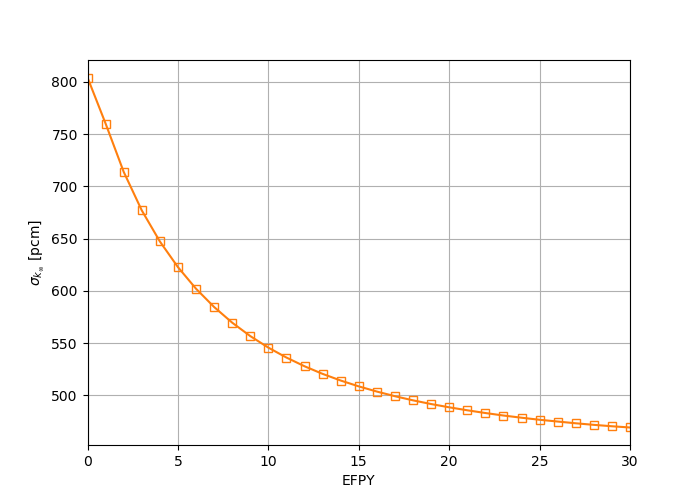

In [6]:
std_k_pwr = np.loadtxt('./pwr_pincell.out')
# Initialize figure
fig_keff_std = matplotlib.pyplot.figure(3, figsize=[7,5])
ax = fig_keff_std.add_subplot(111)
ax.set_prop_cycle(color=colors[1:])
ax.grid(True)
ax.plot(np.linspace(0, 10950, 31)/365.0, std_k, '-s', label='TAP', markerfacecolor="None", linewidth=1.5)
#ax.plot(bu_ds, std_k_pwr, '-o', label='PWR', markerfacecolor="None")

#ax.legend(loc=0)
ax.set_ylabel(r'$\sigma_{k_{\infty}}$ [pcm]')
#ax.set_xlabel('Burnup (GWd/MTU)')
ax.set_xlabel('EFPY')
ax.set_xlim(0, 30)
#ax.set_title('Multiplication factor uncertanty for 540 d of burnup')
fig_keff_std.show()
#fig_keff_std.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/scale_kinf_dynamics_for_tap.png', bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


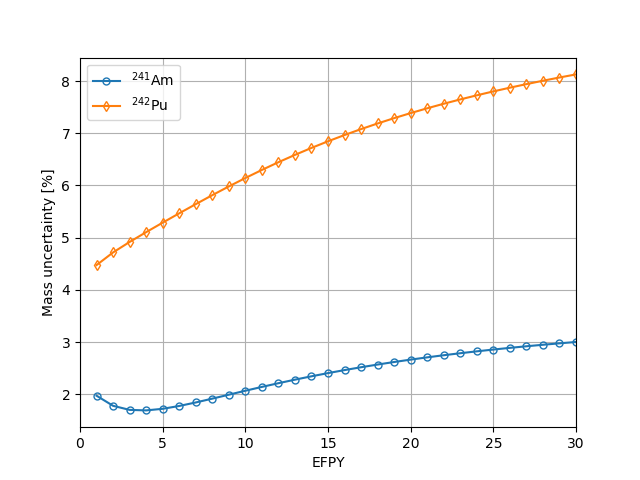

Pu238 error 0.000000 %
(800,)


In [15]:
markers=itertools.cycle(('o','d','*','v','s','^','<','>','p','P','h','H','+','x','X','D','|','_'))
# plot_list = ['U235', 'U236','U238'] 
# plot_list = ['Pu239','Pu240', 'Pu241'] 
# plot_list = ['Xe135', 'I135']
plot_list = ['Am241', 'Pu242'] 

# Initialize figure
fig_rel_error = matplotlib.pyplot.figure(4)
ax = fig_rel_error.add_subplot(111)
ax.grid(True)

for iso in plot_list:
    m=next(markers)
    el_aaa = elem_aaa(iso)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax.plot(np.linspace(365, 10950, 30)/365.0, mass_rel[iso][1:], '-s', label=k_name, markersize=5, marker=m, markerfacecolor="None")

ax.legend(loc=0)
ax.set_ylabel(r'Mass uncertainty [%]')
ax.set_xlabel('EFPY')
ax.set_xlim(0, 30)
#ax.set_ylim(1, 2)
#ax.set_title('Uncertainty from Serpent in mass of major isotopes in the TAP')
fig_rel_error.show()
#fig_rel_error.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/scale_mass_std_act.png', bbox_inches='tight', dpi=700)
print('Pu238 error %f %%' %(mass_rel['Pu238'][0]))
print(depletion[:,iso_names.index('Xe135'),-1].shape)

/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: i

<IPython.core.display.Javascript object>


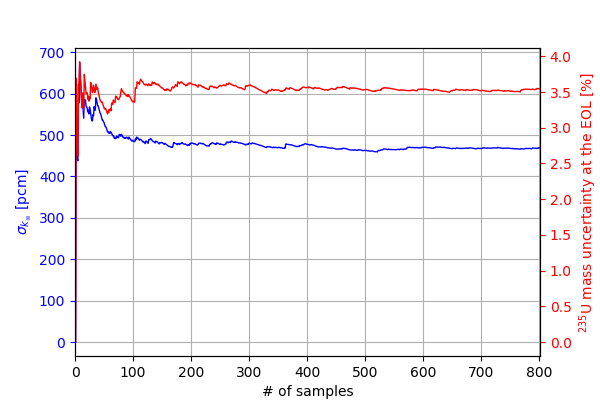

In [19]:
#sample_number_list = np.arange(290, 1010, 10)
sample_number_list = np.arange(0, fnume+1, 1)
std_samp_conv_k = []
std_samp_conv = []

for num in sample_number_list:
    std_samp_conv_k.append(1e5*np.std(k_ds_array[:num,-1]))
    # mass in kg
    #std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1])/ \
    #                         np.median(depletion[:num,iso_names.index('U235'),-1]))
    std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1]) /\
                         np.median(depletion[:num,iso_names.index('U235'),-1]))

# Initialize figure
fig_std_convergance_k = matplotlib.pyplot.figure(5, figsize=[6,4])
ax1 = fig_std_convergance_k.subplots()
ax1.grid(True)
ax1.plot(sample_number_list, std_samp_conv_k, '-', linewidth=1.0, color='b')

ax1.tick_params('y', colors='b')
ax1.set_ylabel(r'$\sigma_{k_{\infty}}$ [pcm]', color='b')
ax1.set_xlabel('# of samples')
ax1.set_xlim(0, len(sample_number_list))

ax2 = ax1.twinx()
ax2.set_prop_cycle(color=colors[1:])
ax2.set_ylabel(r'$^{235}$U mass uncertainty at the EOL [%]', color='red')
ax2.plot(sample_number_list, std_samp_conv, '-', linewidth=1.0, color='r')
#ax2.legend(loc=1)
#ax2.set_ylim(0, 3.2)
ax2.tick_params('y', colors='r')

fig_std_convergance_k.show()
# fig_std_convergance_k.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/scale_convergance_for_tap.png', bbox_inches='tight', dpi=700)